In [1]:
import bioframe
import cooler
import cooltools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Fontanka: fountains calling for WAPL/CTCF depletion in mESC

This notebook is an adaptation of the fountains calling procedure described in https://github.com/agalitsyna/fontanka.

## Define the pattern for calling

In [2]:
ocis = pd.read_csv('ocis.bed', sep = '\t', header = None)
ocis.columns = ['chrom', 'start', 'end']
ocis.head()

,chrom,start,end
0,chr1,15700001,16100000
1,chr1,17200001,17500000
2,chr1,20600001,21300000
3,chr1,23800001,24000000
4,chr1,46800001,47100000


In [3]:
RESOLUTION = 20000

cw_0h = cooler.Cooler(f'/DATA/users/magnitov/wapl_ctcf/contact_maps/hicpro_maps/WAPL_CTCF_0h.mcool::resolutions/{RESOLUTION}')
cw_6h = cooler.Cooler(f'/DATA/users/magnitov/wapl_ctcf/contact_maps/hicpro_maps/WAPL_CTCF_6h.mcool::resolutions/{RESOLUTION}')
cw_24h = cooler.Cooler(f'/DATA/users/magnitov/wapl_ctcf/contact_maps/hicpro_maps/WAPL_CTCF_24h.mcool::resolutions/{RESOLUTION}')
cw_96h = cooler.Cooler(f'/DATA/users/magnitov/wapl_ctcf/contact_maps/hicpro_maps/WAPL_CTCF_96h.mcool::resolutions/{RESOLUTION}')

mm10_view_df = bioframe.make_viewframe(bioframe.fetch_chromsizes('mm10', as_bed = True).query("chrom not in ['chrM']"))
expected_cw_0h = cooltools.expected_cis(cw_0h, view_df = mm10_view_df, ignore_diags = 2, nproc = 24)
expected_cw_6h = cooltools.expected_cis(cw_6h, view_df = mm10_view_df, ignore_diags = 2, nproc = 24)
expected_cw_24h = cooltools.expected_cis(cw_24h, view_df = mm10_view_df, ignore_diags = 2, nproc = 24)
expected_cw_96h = cooltools.expected_cis(cw_96h, view_df = mm10_view_df, ignore_diags = 2, nproc = 24)

In [4]:
stack_0h = cooltools.pileup(cw_0h, ocis, view_df=mm10_view_df, expected_df=expected_cw_0h, flank=1_000_000)
mtx_0h = np.nanmean(stack_0h, axis=2)

stack_6h = cooltools.pileup(cw_6h, ocis, view_df=mm10_view_df, expected_df=expected_cw_6h, flank=1_000_000)
mtx_6h = np.nanmean(stack_6h, axis=2)

stack_24h = cooltools.pileup(cw_24h, ocis, view_df=mm10_view_df, expected_df=expected_cw_24h, flank=1_000_000)
mtx_24h = np.nanmean(stack_24h, axis=2)

stack_96h = cooltools.pileup(cw_96h, ocis, view_df=mm10_view_df, expected_df=expected_cw_96h, flank=1_000_000)
mtx_96h = np.nanmean(stack_96h, axis=2)

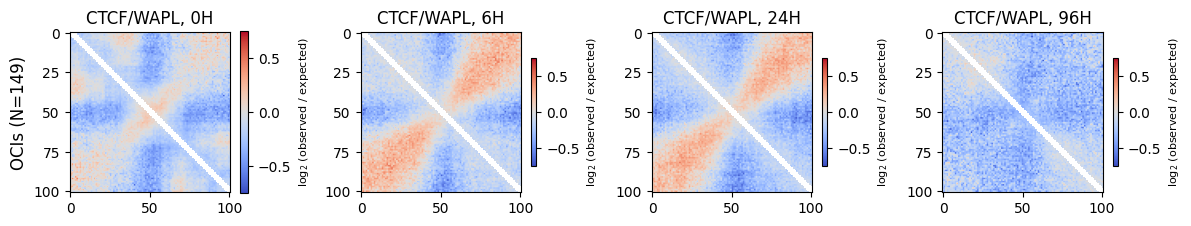

In [5]:
plt.figure(figsize = (12, 3))
           
plt.subplot(141)
plt.title('CTCF/WAPL, 0H', fontsize = 12)
plt.imshow(np.log2(mtx_0h), vmin = -0.75, vmax = 0.75, cmap = 'coolwarm', interpolation=None)
plt.ylabel(f'OCIs (N={len(ocis)})', fontsize = 12)
cbar = plt.colorbar(shrink = 0.6)
cbar.set_label('log$_2$ (observed / expected)', fontsize = 8)

plt.subplot(142)
plt.title('CTCF/WAPL, 6H', fontsize = 12)
plt.imshow(np.log2(mtx_6h), vmin = -0.75, vmax = 0.75, cmap = 'coolwarm', interpolation=None)
cbar = plt.colorbar(shrink = 0.4)
cbar.set_label('log$_2$ (observed / expected)', fontsize = 8)

plt.subplot(143)
plt.title('CTCF/WAPL, 24H', fontsize = 12)
plt.imshow(np.log2(mtx_24h), vmin = -0.75, vmax = 0.75, cmap = 'coolwarm', interpolation=None)
cbar = plt.colorbar(shrink = 0.4)
cbar.set_label('log$_2$ (observed / expected)', fontsize = 8)

plt.subplot(144)
plt.title('CTCF/WAPL, 96H', fontsize = 12)
plt.imshow(np.log2(mtx_96h), vmin = -0.75, vmax = 0.75, cmap = 'coolwarm', interpolation=None)
cbar = plt.colorbar(shrink = 0.4)
cbar.set_label('log$_2$ (observed / expected)', fontsize = 8)

plt.tight_layout()
plt.show()

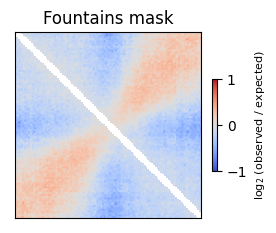

In [6]:
plt.figure(figsize = (3, 3))
plt.title('Fountains mask')
plt.imshow((np.log2(mtx_6h)+np.log2(mtx_24h))/2, vmin = -1, vmax = 1, cmap = 'coolwarm', interpolation=None)
cbar = plt.colorbar(shrink = 0.4)
cbar.set_label('log$_2$ (observed / expected)', fontsize = 8)
plt.xticks([], [])
plt.yticks([], [])
plt.show()

In [7]:
np.save('average_oci.npy', (np.log2(mtx_6h)+np.log2(mtx_24h))/2)

## Run fontanka, apply pattern mask and obtain the fountain score for each genomic snippet

### Prepare viewframes and bins

In [8]:
RESOLUTION = 20000
clr = cooler.Cooler(f'/DATA/users/magnitov/wapl_ctcf/contact_maps/WAPL_CTCF_merged_6h_24h.mcool::resolutions/{RESOLUTION}')

chromsizes = bioframe.fetch_chromsizes('mm10', as_bed=True).query("chrom not in ['chrM']")
chromnames = [x for x in clr.chromnames if x in chromsizes.chrom.values]

cens = bioframe.fetch_centromeres('mm10')
arms = bioframe.make_chromarms(chromsizes, cens, cols_chroms=chromsizes.columns)
arms.start = arms.start.astype(int)
arms.end = arms.end.astype(int)
arms.loc[:, 'name'] = arms.apply(lambda x: f"{x.chrom}:{x.start}-{x.end}", axis=1)

arms = bioframe.sort_bedframe(arms, chromsizes.set_index('chrom').loc[chromnames, :].reset_index())

bins = clr.bins()[:]
bins = bioframe.overlap(bins, arms, how="left", return_index=True).dropna(subset="start_").drop_duplicates('index').set_index('index') # Clean up those bins that do not fall into selected chromosome arms
bins = bins[['chrom', 'start', 'end', 'weight']]

offset = 5*RESOLUTION
bad_bins = bins.loc[np.isnan(bins.weight),:]
bad_bins = bioframe.expand(bad_bins, offset)
bad_bins = bioframe.trim(bad_bins, arms).dropna(subset='start')

good_bins = bioframe.subtract(bins, bad_bins)[['chrom', 'start', 'end']]

### Read the resulting fountain calls

In [9]:
df_fountains = pd.read_table("/DATA/users/magnitov/wapl_ctcf/fountains/plume_calls/fountains/WAPL_CTCF_merged_6h_24h.fontanka.plumes.output.tsv")

In [10]:
df_fountains.dropna().head()

,Unnamed: 0,chrom,start,end,window_start,window_end,FS,FS_peaks,Scharr_box
107,107,chr1,2140000,2160000,1140000,3160000,0.168941,0.585911,12.013170
110,110,chr1,2200000,2220000,1200000,3220000,-0.044106,0.153780,34.466316
113,113,chr1,2260000,2280000,1260000,3280000,-0.017724,0.078701,34.466316
116,116,chr1,2320000,2340000,1320000,3340000,0.205059,0.373456,34.466316
122,122,chr1,2440000,2460000,1440000,3460000,0.101623,0.124679,39.522276


### Comparison between manually called and automatically called peaks of fountain score

In [11]:
ocis = pd.read_table("/DATA/users/magnitov/wapl_ctcf/fountains/plumes_atac.bed", header=None)
ocis.columns = ["chrom", "start", "end"]

In [12]:
# Reset numeric columns of non-trustworthy bins to nans:
columns = df_fountains.columns
columns_reset = ['FS', 'FS_peaks', 'Scharr_box']
df_overlap = bioframe.overlap(df_fountains, good_bins, 
                     how='left', 
                     return_index=True,
                     suffixes=['', '_'] ).drop_duplicates('index')
df_fountains.loc[pd.isna(df_overlap.start_), columns_reset] = np.nan
df_fountains = df_fountains[columns]

In [13]:
# Allowed offset to call a fountain a hit
offset = 5 * RESOLUTION

In [14]:
df_confirmed = bioframe.overlap(ocis, 
                                bioframe.expand(df_fountains.dropna(subset = 'FS_peaks'), offset), 
                                return_index=True, 
                                how = 'left').sort_values('FS_peaks_').drop_duplicates('index').dropna(subset = 'chrom_')

In [15]:
print('Number of ATAC-seq plumes in the annotation:', ocis.groupby('chrom').count().sum()[0])
print('Number of ATAC-seq plumes detected as putative peak by fontanka:', df_confirmed.groupby('chrom').count().sum()[0])

Number of ATAC-seq plumes in the annotation: 149
Number of ATAC-seq plumes detected as putative peak by fontanka: 144


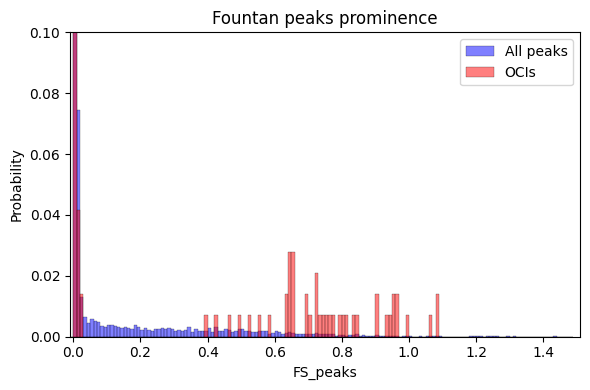

In [19]:
value = "FS_peaks"
title = "Fountan peaks prominence"

plt.figure(figsize = (6, 4))
plt.title(title)

sns.histplot(df_fountains.dropna(subset = "FS_peaks")[value], 
             color = 'blue', alpha = 0.5, stat = 'probability',
             bins = np.arange(-0.3, 1.5, 0.01), label = 'All peaks')

sns.histplot(df_confirmed[value + "_"], 
             color = 'red', alpha = 0.5, stat = 'probability',
             bins = np.arange(-0.3, 1.5, 0.01), label = 'OCIs')
plt.xlim(-0.01, 1.51)
plt.ylim(0, 0.1)

plt.legend()
plt.tight_layout()

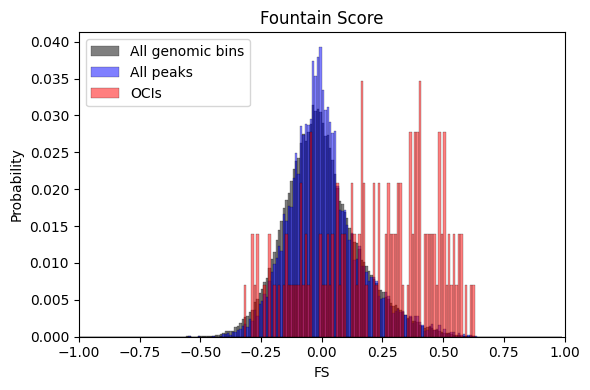

In [20]:
value = "FS"
title = "Fountain Score"

plt.figure(figsize = (6, 4))
plt.title(title)

sns.histplot(df_fountains[value], 
             color = 'black', alpha = 0.5, stat = 'probability',
             bins = np.arange(-1.0, 1.0, 0.01), label = 'All genomic bins')

sns.histplot(df_fountains.dropna(subset = "FS_peaks")[value], 
             color = 'blue', alpha = 0.5, stat = 'probability',
             bins = np.arange(-1.0, 1.0, 0.01), label = 'All peaks')

sns.histplot(df_confirmed[value + "_"], 
             color = 'red', alpha = 0.5, stat = 'probability',
             bins = np.arange(-1.0, 1.0, 0.01), label = 'OCIs')
plt.xlim(-1.0, 1.0)

plt.legend()
plt.tight_layout()

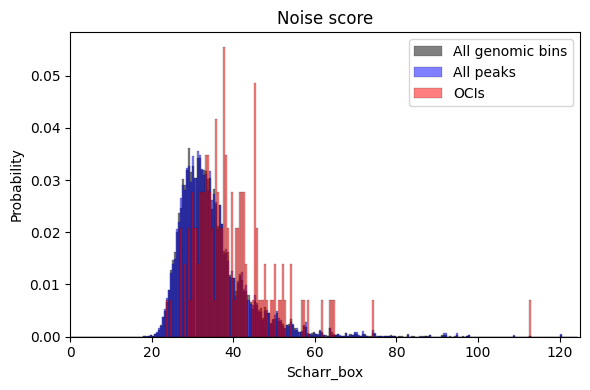

In [21]:
value = "Scharr_box"
title = "Noise score"

plt.figure(figsize = (6, 4))
plt.title(title)

sns.histplot(df_fountains[value], 
             color = 'black', alpha = 0.5, stat = 'probability',
             bins = np.arange(0, 125, 0.5), label = 'All genomic bins')

sns.histplot(df_fountains.dropna(subset = "FS_peaks")[value], 
             color = 'blue', alpha = 0.5, stat = 'probability',
             bins = np.arange(0, 125, 0.5), label = 'All peaks')

sns.histplot(df_confirmed[value + "_"], 
             color = 'red', alpha = 0.5, stat = 'probability',
             bins = np.arange(0, 125, 0.5), label = 'OCIs')

plt.xlim(0, 125)

plt.legend()
plt.tight_layout()

### Threshold by peak prominence

In [22]:
# Apply thresholding to cut off huge peak in the distribution on the left: 
from skimage.filters import threshold_li

peak_prominence_th = threshold_li(df_fountains.FS_peaks.values)
print(peak_prominence_th)

0.09563161427065257


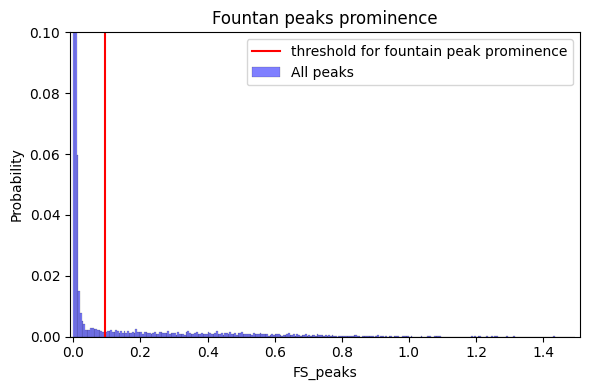

In [23]:
value = "FS_peaks"
title = "Fountan peaks prominence"

plt.figure(figsize = (6, 4))

sns.histplot(df_fountains.dropna(subset = "FS_peaks")[value], 
             color = 'blue', alpha = 0.5, stat = 'probability',
             bins = np.arange(-0.01, 1.5, 0.005), label = 'All peaks')

plt.axvline(peak_prominence_th, color='red', label='threshold for fountain peak prominence')

plt.xlim(-0.01, 1.51)
plt.ylim(0, 0.1)

plt.title(title)
plt.legend()
plt.tight_layout()

In [24]:
df_fountains.loc[df_fountains['FS_peaks']<=peak_prominence_th, 'FS_peaks'] = np.nan

In [27]:
print('Number of OCIs in the annotation:', ocis.groupby('chrom').count().sum()[0])
print('Number of OCIs detected as putative peak by fontanka:', df_confirmed.groupby('chrom').count().sum()[0])

Number of OCIs in the annotation: 149
Number of OCIs detected as putative peak by fontanka: 144


In [28]:
df_ocis = bioframe.overlap(ocis, 
                             bioframe.expand(df_fountains.dropna(subset = 'FS_peaks'), offset), 
                             return_index=True, 
                             how = 'left').sort_values('FS_peaks_').drop_duplicates('index').dropna(subset = 'chrom_')

In [29]:
print('Number of OCIs in the annotation:', ocis.groupby('chrom').count().sum()[0])
print('Number of OCIs passing the peak prominence threshold:', df_ocis.groupby('chrom').count().sum()[0])

Number of OCIs in the annotation: 149
Number of OCIs passing the peak prominence threshold: 120


### Threshold by fountain score

In [30]:
# require positive correlation
fountain_threshold = 0 

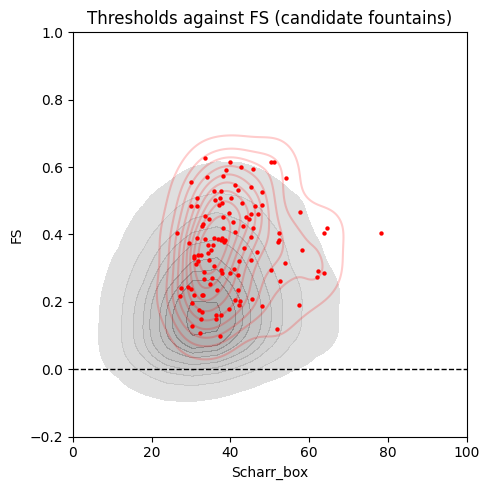

In [31]:
value_x = "Scharr_box"
value_y = "FS"

plt.figure(figsize = (5, 5))
plt.title('Thresholds against FS (candidate fountains)')

sns.kdeplot(data = df_fountains.dropna(subset = "FS_peaks"), x = value_x, y = value_y, color = 'black', alpha = 0.5, fill = True)
sns.scatterplot(data = df_ocis, x = value_x + "_", y = value_y + "_", color = 'red', alpha = 1, s = 10, linewidth = 0)
sns.kdeplot(data = df_ocis, x = value_x + "_", y = value_y + "_", color = 'red', alpha = 0.2)

plt.ylim(-0.2, 1)
plt.xlim(0, 100)

plt.axhline(fountain_threshold, ls = '--', color='black', linewidth=1)
plt.tight_layout()
plt.show()

## Plume calling
We considered the 6h and 24h of IAA treatment samples as replicates

In [32]:
# Apply three filters: 
# 1) Li thresholding for Fountain Score peak prominence for each datset,
# 2) Positive Fountain Score (positive correlation with average fountain),
# 3) Consider only good bins, at least 100kb away from the unbalanced "bad" bins.

fountain_threshold = 0 

dfs = {}
for experiment in ['WAPL_CTCF_merged_6h_24h', 'WAPL_CTCF_6h', 'WAPL_CTCF_24h']:
    
    df = pd.read_table(f"/DATA/users/magnitov/wapl_ctcf/fountains/plume_calls/fountains/{experiment}.fontanka.plumes.output.tsv").copy()
    columns = list(df.columns)
    
    # Filter only strong peaks:
    fountain_peak_th = threshold_li(df.FS_peaks.values)
    df.loc[:, 'is_peak_prominent'] = False
    fountain_peak_mask = df['FS_peaks'] > fountain_peak_th
    df.loc[fountain_peak_mask, 'is_peak_prominent'] = True

    # Filter only trustworthy, good bins: 
    df_overlap = bioframe.overlap(df, good_bins, 
                                  how = 'left', 
                                  return_index = True,
                                  suffixes = ['', '_'] ).drop_duplicates('index')
    is_bad_bin_mask = pd.isna(df_overlap.start_)
    df.loc[:, 'is_good_bin'] = False
    df.loc[~is_bad_bin_mask, 'is_good_bin'] = True
    
    # Filter only positively correlating with fountain mask:
    fountain_mask = df.eval(f'FS>{fountain_threshold}')
    df.loc[:, 'is_FS_positive'] = False
    df.loc[fountain_mask, 'is_FS_positive'] = True
    
    df = df[columns + ['is_peak_prominent', 'is_FS_positive', 'is_good_bin']]
    dfs[experiment] = df.copy()

In [33]:
def filter_reproducible(df, df_rep, offset):
    df = bioframe.overlap(df, 
                          bioframe.expand(df_rep, offset), 
                          how = 'left', 
                          return_index = True,
                          suffixes = ['', '_'] ).dropna(subset = ['chrom_']).drop_duplicates(['chrom', 'start'])
    df = df.set_index('index')
    df = df.drop(['index_'], axis = 1)
    df = df[columns]
    print("Confirmed fountains: ", len(df))
    
    return df

In [34]:
# Reproducible peaks between the replicates at 6 and 24 hours depletion
# Fountains detected in the merged dataset should be detected in 6 and 24 hours samples with an offset of 60 kb

offset = 3*RESOLUTION
exp, exp_rep1, exp_rep2 = ('WAPL_CTCF_merged_6h_24h', 'WAPL_CTCF_6h', 'WAPL_CTCF_24h')

df = dfs[exp].query('(is_peak_prominent)&(is_FS_positive)&(is_good_bin)')
columns = df.columns

print(len(df))

df_rep1 = dfs[exp_rep1].query('(is_peak_prominent)&(is_FS_positive)&(is_good_bin)')
df_rep2 = dfs[exp_rep2].query('(is_peak_prominent)&(is_FS_positive)&(is_good_bin)')

df = filter_reproducible(df, df_rep1, offset)
df = filter_reproducible(df, df_rep2, offset)

1775
Confirmed fountains:  1574
Confirmed fountains:  1372


In [35]:
df_filtered = df.copy()

In [36]:
# remove top noisy regions
noise_threshold = np.nanpercentile(df_filtered["Scharr_box"], 90)

df_no_top_noisy = df_filtered.query(f"Scharr_box<{noise_threshold}") 

In [37]:
for df in dfs.values():
    df.loc[:, 'is_not_noisy'] = df.loc[:, "Scharr_box"]<noise_threshold
    
df_filtered.loc[:, 'is_not_noisy'] = df_filtered.loc[:, "Scharr_box"]<noise_threshold
df_no_top_noisy.loc[:, 'is_not_noisy'] = df_no_top_noisy.loc[:, "Scharr_box"]<noise_threshold

In [38]:
len(df_no_top_noisy)

1234

In [39]:
# remove bottom regions with low fountain score
FS_threshold = np.nanpercentile(df_filtered["FS"], 30)

df_no_top_noisy = df_no_top_noisy.query(f"FS>{FS_threshold}") 

In [40]:
len(df_no_top_noisy)

852

## Visualization and saving the output

In [41]:
offset = 5*RESOLUTION
df_confirmed = bioframe.overlap(ocis, 
                                bioframe.expand(df_no_top_noisy, offset), 
                                return_index = True, 
                                how = 'left').sort_values('FS_peaks_').drop_duplicates('index').dropna(subset = 'chrom_')

In [42]:
print('Number of ATAC-seq plumes in the annotation:', ocis.groupby('chrom').count().sum()[0])
print('Number of ATAC-seq plumes passing the filters:', df_confirmed.groupby('chrom').count().sum()[0])

Number of ATAC-seq plumes in the annotation: 149
Number of ATAC-seq plumes passing the filters: 82


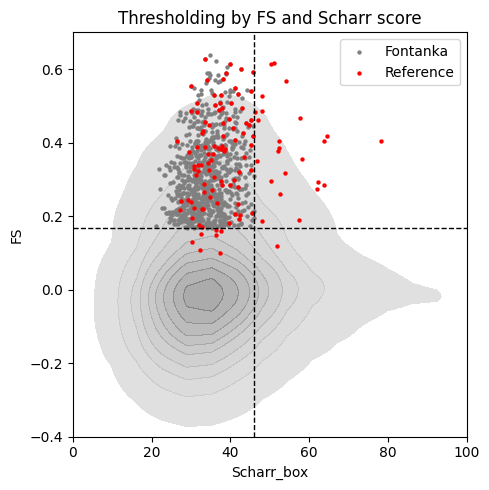

In [43]:
value_x = "Scharr_box"
value_y = "FS"

plt.figure(figsize = (5, 5))
plt.title('Thresholding by FS and Scharr score')

sns.kdeplot(data = dfs['WAPL_CTCF_merged_6h_24h'].dropna(subset = "FS_peaks"), 
            x = value_x, y = value_y, color = 'black', alpha = 0.5, fill = True)
sns.scatterplot(data = df_no_top_noisy, 
                x = value_x, y = value_y, color = 'grey', alpha = 1, s = 10, linewidth = 0, label = 'Fontanka')
sns.scatterplot(data = df_ocis, 
                x = value_x + "_", y = value_y + "_", color = 'red', alpha = 1, s = 10, linewidth = 0, label = 'Reference')

plt.xlim(0, 100)
plt.ylim(-0.4, 0.7)

plt.axhline(FS_threshold, ls = '--', color = 'black', linewidth = 1)
plt.axvline(noise_threshold, ls = '--', color = 'black', linewidth = 1)

plt.legend()
plt.tight_layout()
plt.show()

In [45]:
df_no_top_noisy

,Unnamed: 0,chrom,start,end,window_start,window_end,FS,FS_peaks,Scharr_box,is_peak_prominent,is_FS_positive,is_good_bin,is_not_noisy
index,,,,,,,,,,,,,
353,353.0,chr1,7060000,7080000,6060000.0,8080000.0,0.270921,0.398028,38.867075,True,True,True,True
569,569.0,chr1,11380000,11400000,10380000.0,12400000.0,0.292883,0.516935,33.513817,True,True,True,True
787,787.0,chr1,15740000,15760000,14740000.0,16760000.0,0.219703,0.421406,32.803289,True,True,True,True
1047,1047.0,chr1,20940000,20960000,19940000.0,21960000.0,0.592884,1.060889,45.805211,True,True,True,True
1198,1198.0,chr1,23960000,23980000,22960000.0,24980000.0,0.321998,0.525903,31.781342,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
129638,129638.0,chrX,129780000,129800000,128780000.0,130800000.0,0.223493,0.479157,44.361735,True,True,True,True
129682,129682.0,chrX,130660000,130680000,129660000.0,131680000.0,0.180747,0.248395,38.275004,True,True,True,True
130908,130908.0,chrX,155180000,155200000,154180000.0,156200000.0,0.194590,0.341433,46.032856,True,True,True,True


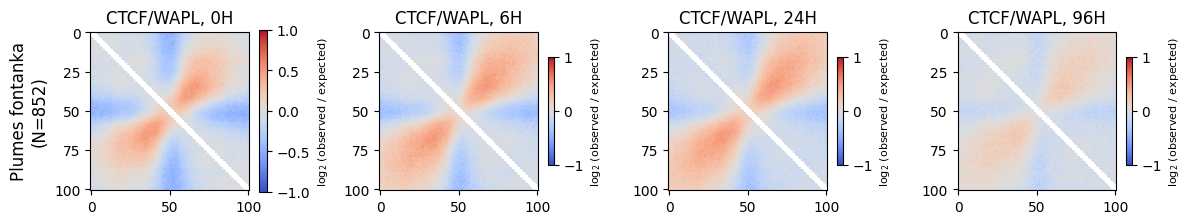

In [46]:
stack_0h = cooltools.pileup(cw_0h, df_no_top_noisy, view_df=mm10_view_df, expected_df=expected_cw_0h, flank=1_000_000, nproc=24)
mtx_0h = np.nanmean(stack_0h, axis=2)

stack_6h = cooltools.pileup(cw_6h, df_no_top_noisy, view_df=mm10_view_df, expected_df=expected_cw_6h, flank=1_000_000, nproc=24)
mtx_6h = np.nanmean(stack_6h, axis=2)

stack_24h = cooltools.pileup(cw_24h, df_no_top_noisy, view_df=mm10_view_df, expected_df=expected_cw_24h, flank=1_000_000, nproc=24)
mtx_24h = np.nanmean(stack_24h, axis=2)

stack_96h = cooltools.pileup(cw_96h, df_no_top_noisy, view_df=mm10_view_df, expected_df=expected_cw_96h, flank=1_000_000, nproc=24)
mtx_96h = np.nanmean(stack_96h, axis=2)

plt.figure(figsize = (12, 3))
           
plt.subplot(141)
plt.title('CTCF/WAPL, 0H', fontsize = 12)
plt.imshow(np.log2(mtx_0h), vmin = -1, vmax = 1, cmap = 'coolwarm', interpolation=None)
plt.ylabel(f'Plumes fontanka\n(N={len(df_no_top_noisy)})', fontsize = 12)
cbar = plt.colorbar(shrink = 0.6)
cbar.set_label('log$_2$ (observed / expected)', fontsize = 8)

plt.subplot(142)
plt.title('CTCF/WAPL, 6H', fontsize = 12)
plt.imshow(np.log2(mtx_6h), vmin = -1, vmax = 1, cmap = 'coolwarm', interpolation=None)
cbar = plt.colorbar(shrink = 0.4)
cbar.set_label('log$_2$ (observed / expected)', fontsize = 8)

plt.subplot(143)
plt.title('CTCF/WAPL, 24H', fontsize = 12)
plt.imshow(np.log2(mtx_24h), vmin = -1, vmax = 1, cmap = 'coolwarm', interpolation=None)
cbar = plt.colorbar(shrink = 0.4)
cbar.set_label('log$_2$ (observed / expected)', fontsize = 8)

plt.subplot(144)
plt.title('CTCF/WAPL, 96H', fontsize = 12)
plt.imshow(np.log2(mtx_96h), vmin = -1, vmax = 1, cmap = 'coolwarm', interpolation=None)
cbar = plt.colorbar(shrink = 0.4)
cbar.set_label('log$_2$ (observed / expected)', fontsize = 8)

plt.tight_layout()
plt.show()

In [47]:
df_no_top_noisy[['chrom', 'start', 'end']].to_csv("fountains_fontanka_merged.bed", sep = '\t', index = 0, header = 0)